In [2]:
import target
import joblib
import importlib
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from target import calculate_target
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

importlib.reload(target)

<module 'target' from '/home/samu/MarGui-Project3/target.py'>

In [3]:
# Parametri di simulazione
ticker = "AAPL"
TimeSplit_up = "2025-11-28"
TimeSplit_down = "2024-09-26"
starting_cash = 1000
window = 40
floor_probability = 0.4
commission_interest = 0.002

In [5]:
# --- Carica dati e modello ---
start_dt = pd.to_datetime(TimeSplit_down)
end_dt = pd.to_datetime(TimeSplit_up)

df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,
    parse_dates=[0],
    date_format="ISO8601"
)

bundle = joblib.load(f"models/{ticker}.joblib")
scaler = bundle.get("scaler", None)  # legacy
model = bundle["model"]
features = bundle["features"]
params = bundle["param"]

print(features)
print(params)

aggressive = bundle.get("aggressive", bundle.get("aggresive", None))
threshold = bundle.get("threshold", bundle.get("threshodl", None))
test_slice = df.loc[(df.index >= start_dt) & (df.index <= end_dt)].copy()

entry = {
    "model": model,
    "features": features,
    "test_data": test_slice
}

if aggressive is not None:
    entry["aggressive"] = aggressive
    val_data = df.loc[df.index < start_dt].copy()
    if len(val_data) >= window:
        warm = val_data.iloc[-window:].copy()
    else:
        warm = val_data.copy()
        print(f"WARNING: Only {len(warm)} days available for warm start (need {window})")

    entry["aggressive_warm_start_sample"] = warm.copy()
if threshold is not None:
    entry["threshold"] = threshold




['Close', 'High', 'Volume', 'Return', 'MACD', 'MACD_Hist', 'SMA', 'EMA20', 'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', '%K', '%D', 'R_EMA20', 'ADX', 'ATR', 'ROC', 'OBV', 'CMF', 'MACD_norm', 'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', 'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', 'RSI_x_Vol_Change', 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 'SP_Return', 'SP_RSI', 'SP_Dist_SMA']
{'eta': 0.04975380078332261, 'min_child_weight': 28, 'max_depth': 6, 'gamma': 3.2626390973146395, 'lambda': 6.3563160000083, 'alpha': 2.432341231995148, 'scale_pos_weight': 1.3387270118713261, 'subsample': 0.8059808539662016, 'colsample_bytree': 0.663969889993363, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'booster': 'gbtree', 'random_state': 42}


In [12]:
# Baseline: Buy and Hold con costi di commissione
print("=" * 10 + f"{ticker}" + "=" * 10)


own_tikers = (starting_cash * (1-commission_interest))  / entry["test_data"].iloc[0]["Close"]

payout_bnh = own_tikers * entry["test_data"].iloc[-1]["Close"]
payout_bnh = payout_bnh * (1-commission_interest)

==========AAPL==========


In [13]:
# Baseline: Trend Chaser 
print("=" * 10 + f"{ticker}" + "=" * 10)

trend_chaser = {
    "cash": starting_cash,
    "shares": 0.0,
    "prev_price": None,
    "up_streak": 0,      
    "down_streak": 0,    
    "threshold": 2,     
    "data": entry["test_data"].copy()
}

def step(row):
    price = float(row["Close"])
    prev = trend_chaser["prev_price"]

    # Inizializza alla prima riga
    if prev is None:
        trend_chaser["prev_price"] = price
        portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price
        return portfolio

    # Aggiorna le streak in base al movimento del prezzo
    if price > prev:
        trend_chaser["up_streak"] += 1
        trend_chaser["down_streak"] = 0
    elif price < prev:
        trend_chaser["down_streak"] += 1
        trend_chaser["up_streak"] = 0
    # Se price == prev, mantieni le streak correnti
    
    # Segnale di acquisto: forte trend al rialzo rilevato e abbiamo liquidità
    if (trend_chaser["up_streak"] >= trend_chaser["threshold"] and 
        trend_chaser["cash"] > 0):
        shares_to_buy = trend_chaser["cash"]* (1 - commission_interest) / price
        trend_chaser["shares"] += shares_to_buy
        trend_chaser["cash"] = 0.0
    
    # Segnale di vendita: forte trend al ribasso rilevato e abbiamo azioni
    elif (trend_chaser["down_streak"] >= trend_chaser["threshold"] and 
            trend_chaser["shares"] > 0):
        cash_from_sale = trend_chaser["shares"] * price
        trend_chaser["cash"] += cash_from_sale * (1 - commission_interest)
        trend_chaser["shares"] = 0.0

    trend_chaser["prev_price"] = price
    portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price

    return portfolio

trend_chaser["data"].loc[:, "portfolio_value"] = trend_chaser["data"].apply(step, axis=1)

# Calcola il payout finale
final_price = trend_chaser["data"].iloc[-1]["Close"]
payout_tc = trend_chaser["cash"] + (trend_chaser["shares"] * final_price)

==========AAPL==========


In [14]:
# Strategia del modello
print("=" * 10 + f"{ticker}" + "=" * 10)

model_state = {
    "model": entry["model"],
    "cash": starting_cash,
    "shares": 0.0,
    "streak": 0
}

model = model_state["model"]

# Copio i dati
test_df = entry["test_data"].copy()
model_state["data"] = test_df



if "aggressive" in entry:
    model_state["aggressive"] = entry["aggressive"]
    
    # Filtro i set per le feature di cui ho bisogno
    warm_start_features = entry["aggressive_warm_start_sample"][entry["features"]].copy()
    test_features = test_df[entry["features"]].copy()
    
    # Warning se la finsetra di warm start è troppo piccola
    if len(warm_start_features) < window:
        print(f"WARNING: Warm start too small! This may cause issues.")
    
    # Concateno i set per calcolare la threshold
    temp_features = pd.concat([warm_start_features, test_features]).reset_index(drop=True)

    # Uso il modello per predirre
    dmatrix = xgb.DMatrix(temp_features.values, feature_names=entry["features"])
    probability = model.predict(dmatrix, iteration_range=(0, model.best_iteration))
    probability_series = pd.Series(probability).astype(float)

    # Calcolo la threshold secondo le politiche scelte
    roll_mean = probability_series.rolling(window=window, min_periods=window).mean()
    roll_std = probability_series.rolling(window=window, min_periods=window).std()
    dynamic_threshold = roll_mean + roll_std.mul(float(entry["aggressive"]))
    dynamic_threshold = np.maximum(dynamic_threshold, floor_probability)
    
    # Prendo solo predizioni del test
    start_idx = len(warm_start_features)
    probability_series = probability_series.iloc[start_idx:].reset_index(drop=True)
    dynamic_threshold = dynamic_threshold.iloc[start_idx:].reset_index(drop=True)
    
    # Trasformo in azioni (1 or 0)
    actions = (probability_series > dynamic_threshold).astype(int)
    
    # Debug: controllo NaN
    nan_count = dynamic_threshold.isna().sum()
    if nan_count > 0:
        print(f"WARNING: {nan_count} NaN thresholds found! These will be treated as no-trade.")
        actions = actions.fillna(0).astype(int)
    
else:
    # Static threshold path
    if "threshold" in entry:
        model_state["threshold"] = entry["threshold"]
    else:
        model_state["threshold"] = 0.5

    test_features = test_df[entry["features"]].copy()
    dmatrix = xgb.DMatrix(test_features.values, feature_names=entry["features"])
    probability = model.predict(dmatrix, iteration_range=(0, model.best_iteration))
    actions = pd.Series((probability >= model_state["threshold"]).astype(int))

if len(test_df) != len(actions):
    print(f"ERROR: Length mismatch! Test: {len(test_df)}, Actions: {len(actions)}")
    # Riduco alla minima lunghezza per evitare errori
    min_len = min(len(test_df), len(actions))
    test_df = test_df.iloc[:min_len].copy()
    actions = actions.iloc[:min_len]
    model_state["data"] = test_df

# Applico le azioni al data set
model_state["data"] = model_state["data"].copy() 
model_state["data"]["model_action"] = actions.values

def model_strategy(row):
    price = float(row["Close"])

    if row["model_action"] == 1:
        model_state["streak"] = 0
        if model_state["shares"] == 0:
            # Buy completo
            model_state["shares"] += (model_state["cash"] * (1 - commission_interest)) / price
            model_state["cash"] = 0.0
            model_state["streak"] = 0
        
    if row["model_action"] == 0:
        model_state["streak"] += 1
        if model_state["shares"] != 0 and (model_state["streak"] > 5):
            # Vendita totale
            model_state["cash"] += model_state["shares"] * price * (1 - commission_interest)
            model_state["shares"] = 0.0
            model_state["streak"] = 0

    return model_state["cash"] + (model_state["shares"] * price)

# Uso la strategia sul data set
model_state["data"]["model_value"] = model_state["data"].apply(model_strategy, axis=1)

# Final payout
final_price = float(model_state["data"].iloc[-1]["Close"])
payout_mod = model_state["cash"] + (model_state["shares"] * final_price)

==========AAPL==========


Testing sul periodo che va dal 2024-09-26 a 2025-11-28
Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1220.7090201463363 | Guadagno 22.071 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1059.7279693533835 | Guadagno 5.973 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1277.6935575321263 | Guadagno 27.769 %


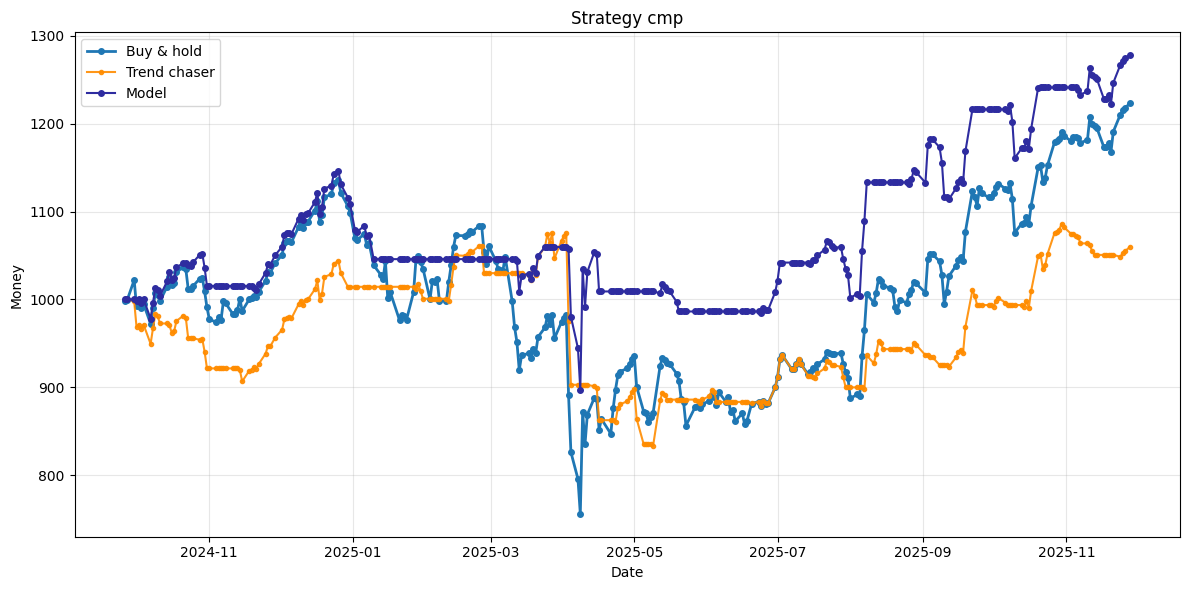

In [19]:
print(f"Testing sul periodo che va dal {test_slice.index[0].date()} a {test_slice.index[-1].date()}")
print(f"Baseline 1: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_bnh} | Guadagno {((payout_bnh - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Baseline 2: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_tc} | Guadagno {((payout_tc - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_mod} | Guadagno {((payout_mod - starting_cash)/starting_cash) * 100:.3f} %")

plt.figure(figsize=(12,6))

# Use the aligned data from model_state
idx = entry["test_data"].index


bh_series = model_state["data"]["Close"] * own_tikers
model_series = model_state["data"]["model_value"]

# For trend chaser, align with same indices if possible
if len(trend_chaser["data"]) == len(model_state["data"]):
    tc_series = trend_chaser["data"]["portfolio_value"].values
else:
    # Try to match by index
    try:
        tc_series = trend_chaser["data"].loc[idx, "portfolio_value"]
    except:
        tc_series = None
        print("Warning: Could not align trend chaser data")

plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)
if tc_series is not None:
    plt.plot(idx, tc_series, label='Trend chaser', color="darkorange", linewidth=1.5, marker='o', markersize=3, alpha=0.9)
plt.plot(idx, model_series, label='Model', color="#2e2ca0", linewidth=1.5, marker='o', markersize=4)

# Show EVERY model action (aligned with model_state data)
buys = model_state["data"]["model_action"] == 1
sells = model_state["data"]["model_action"] == 0

# Use the aligned indices and values from model_state["data"]
buy_indices = model_state["data"].loc[buys].index
buy_values = model_state["data"].loc[buys, "model_value"]

sell_indices = model_state["data"].loc[sells].index
sell_values = model_state["data"].loc[sells, "model_value"]

#plt.scatter(buy_indices, buy_values, marker="^", color="green", s=60, label="Model BUY", zorder=5)
#plt.scatter(sell_indices, sell_values, marker="v", color="red", s=60, label="Model SELL", zorder=5)

plt.title("Strategy cmp")
plt.xlabel("Date")
plt.ylabel("Money")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

==========AAPL - Confusion Matrix==========

=== PREDICTION STATISTICS ===
Mean probability: 0.433851
Mean threshold: 0.479655
Std threshold: 0.024740
Min threshold: 0.443572
Max threshold: 0.531964

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.52      0.23      0.32       120
           0       0.61      0.85      0.71       170

    accuracy                           0.59       290
   macro avg       0.56      0.54      0.52       290
weighted avg       0.57      0.59      0.55       290



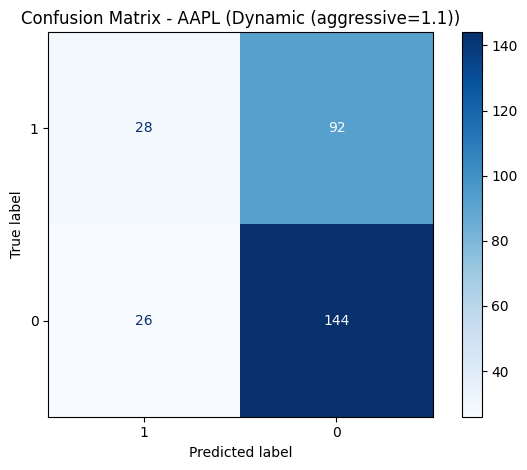

In [16]:
print("=" * 10 + f"{ticker} - Confusion Matrix" + "=" * 10)

test_df = entry["test_data"].copy()

# Calcolo il target se non è presente
if 'Target' not in test_df.columns:
    test_df['Target'] = calculate_target(test_df, profit_take_pct=2, stop_loss_pct=1.0)


test_df = test_df.dropna(subset=["Target"])
test_df['Target'] = test_df['Target'].astype(int)
test_df = test_df.reset_index(drop=True)

if "aggressive" in entry:
    warm_start_features = entry["aggressive_warm_start_sample"][entry["features"]].copy()
    
    # Controllo finestra warm-start
    if len(warm_start_features) < window:
        print(f"ERROR: Warm start too small! Need {window}, got {len(warm_start_features)}")
        print("This will cause NaN thresholds at the start of predictions")
    
    test_features = test_df[entry["features"]].copy()
    temp_features = pd.concat([warm_start_features, test_features]).reset_index(drop=True)
    
    dmatrix = xgb.DMatrix(temp_features.values, feature_names=entry["features"])
    probability = entry["model"].predict(dmatrix, iteration_range=(0, entry["model"].best_iteration))
    probability_series = pd.Series(probability).astype(float)
    
    # Calcoli per threshold dinamica
    roll_mean = probability_series.rolling(window=window, min_periods=window).mean()  
    roll_std = probability_series.rolling(window=window, min_periods=window).std()   
    dynamic_threshold = roll_mean + roll_std.mul(float(entry["aggressive"]))
    dynamic_threshold = np.maximum(dynamic_threshold, floor_probability)
    
    # Predo solo la parte di test
    start_idx = len(warm_start_features)
    probability_series = probability_series.iloc[start_idx:].reset_index(drop=True)
    dynamic_threshold = dynamic_threshold.iloc[start_idx:].reset_index(drop=True)

    # Controllo per NaN
    nan_count = dynamic_threshold.isna().sum()
    if nan_count > 0:
        print(f"WARNING: {nan_count} NaN thresholds found!")
        print(f"First non-NaN threshold at index: {dynamic_threshold.first_valid_index()}")
    
    # Verifico lungezze test
    if len(probability_series) != len(test_df):
        print(f"\n!!! LENGTH MISMATCH !!! Predictions: {len(probability_series)}, Targets: {len(test_df)}")
        min_len = min(len(test_df), len(probability_series))
        test_df = test_df.iloc[:min_len].copy()
        probability_series = probability_series.iloc[:min_len]
        dynamic_threshold = dynamic_threshold.iloc[:min_len]
    
    test_df['Probability'] = probability_series.values
    test_df['Dynamic_Threshold'] = dynamic_threshold.values
    test_df['Prediction'] = (probability_series > dynamic_threshold).astype(int).values

    # DEBUG: Print statistics
    print(f"\n=== PREDICTION STATISTICS ===")
    print(f"Mean probability: {probability_series.mean():.6f}")
    print(f"Mean threshold: {dynamic_threshold.mean():.6f}")
    print(f"Std threshold: {dynamic_threshold.std():.6f}")
    print(f"Min threshold: {dynamic_threshold.min():.6f}")
    print(f"Max threshold: {dynamic_threshold.max():.6f}")
    
    threshold_info = f"Dynamic (aggressive={entry['aggressive']:.1f})"
    
else:
    threshold = entry.get("threshold", 0.5)
    test_features = test_df[entry["features"]].copy()
    dmatrix = xgb.DMatrix(test_features.values, feature_names=entry["features"])
    probability = entry["model"].predict(dmatrix, iteration_range=(0, entry["model"].best_iteration))
    
    test_df['Probability'] = probability
    test_df['Prediction'] = (probability >= threshold).astype(int)
    threshold_info = f"Static (threshold={threshold})"

# Final evaluation
predictions = test_df['Prediction'].values
targets = test_df['Target'].values

print("\nClassification Report (Test Set):")
print(classification_report(targets, predictions, labels=[1, 0]))

cm = confusion_matrix(targets, predictions, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {ticker} ({threshold_info})")
plt.tight_layout()
plt.show()